In [1]:
#import libraries
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
from sodapy import socrata
import geopandas as gpd
import contextily as ctx
import esda 
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt 
import plotly.express as px


In [2]:
#import block grops data
gdf = gpd.read_file('C:/Users/ASUS/Downloads/acs2018_5yr_B01003_15000US060372711003.geojson')


In [3]:
gdf.head()

,geoid,name,B01003001,"B01003001, Error",geometry
0,15000US060371011101,"Block Group 1, Los Angeles, CA",1806.0,332.0,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913..."
1,15000US060371011102,"Block Group 2, Los Angeles, CA",1529.0,375.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
2,15000US060371011103,"Block Group 3, Los Angeles, CA",979.0,250.0,"MULTIPOLYGON (((-118.30080 34.26327, -118.2979..."
3,15000US060371011221,"Block Group 1, Los Angeles, CA",2093.0,410.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
4,15000US060371011222,"Block Group 2, Los Angeles, CA",1146.0,281.0,"MULTIPOLYGON (((-118.29075 34.26906, -118.2906..."


In [4]:
gdf.shape

(2516, 5)

In [5]:
#column selection & renaming
gdf = gdf[['geoid', 'B01003001', 'geometry']]
gdf.columns = ['FIPS', 'TotalPop', 'geometry']

In [6]:
gdf.tail()

,FIPS,TotalPop,geometry
2511,15000US060379800261,37.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
2512,15000US060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
2513,15000US060379800311,1113.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
2514,15000US060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2515,16000US0644000,3959657.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [14]:
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US', '')
gdf.tail()

,FIPS,TotalPop,geometry
2511,060379800261,37.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
2512,060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
2513,060379800311,1113.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
2514,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2515,16000US0644000,3959657.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [20]:
gdf.sort_values('TotalPop').head()

,FIPS,TotalPop,geometry
2509,060379800231,0.0,"MULTIPOLYGON (((-118.64870 34.23120, -118.6480..."
2506,060379800201,0.0,"MULTIPOLYGON (((-118.34412 34.21700, -118.3438..."
2358,060372772002,0.0,"MULTIPOLYGON (((-118.38597 33.94734, -118.3859..."
2514,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2508,060379800221,0.0,"MULTIPOLYGON (((-118.50266 34.30809, -118.5026..."


In [22]:
gdf = gdf[gdf['TotalPop']>100]
gdf.head()

,FIPS,TotalPop,geometry
0,060371011101,1806.0,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913..."
1,060371011102,1529.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
2,060371011103,979.0,"MULTIPOLYGON (((-118.30080 34.26327, -118.2979..."
3,060371011221,2093.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
4,060371011222,1146.0,"MULTIPOLYGON (((-118.29075 34.26906, -118.2906..."


In [24]:
gdf = gdf.to_crs(epsg=3857)

AttributeError: module 'contextily' has no attribute 'add_basemap'

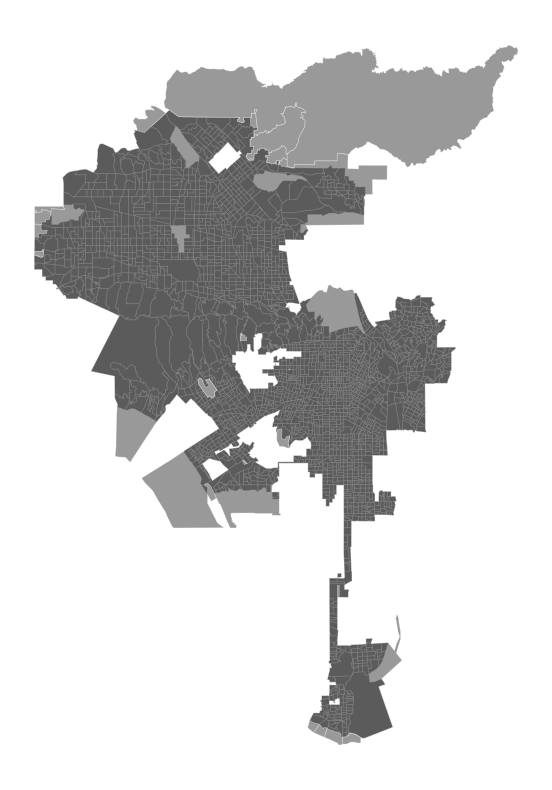

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax,
        color='black',
        edgecolor='white',
        lw=0.5,
        alpha=0.4)
ax.axis('off')
ctx.add_basemap(ax, source=contextily.providers.CartoDB.Position)


In [78]:
arrests = pd.read_csv('C:/Users/ASUS/Downloads/arrests.csv')
arrests.head(3)

,Unnamed: 0,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,...,dispo_desc,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst
0,0,6267132,BOOKING,2021-10-23T00:00:00.000,1000.0,6,Hollywood,669,40,M,...,MISDEMEANOR COMPLAINT FILED,5300 SANTA MONICA BL,34.0929,-118.3048,"{'type': 'Point', 'coordinates': [-118.3048, 3...",2021-10-23T00:00:00.000,1131.0,HOLLYWOOD,4206.0,NaN
1,1,6267204,BOOKING,2021-10-23T00:00:00.000,1350.0,10,West Valley,1039,29,M,...,NaN,VANOWEN,34.1939,-118.4749,"{'type': 'Point', 'coordinates': [-118.4749, 3...",2021-10-23T00:00:00.000,1650.0,VALLEY - JAIL DIV,4279.0,HASKELL
2,2,6267139,BOOKING,2021-10-23T00:00:00.000,1016.0,15,N Hollywood,1503,32,M,...,NaN,HOLLYWOOD FY,34.2003,-118.4002,"{'type': 'Point', 'coordinates': [-118.4002, 3...",2021-10-23T00:00:00.000,1207.0,VALLEY - JAIL DIV,4279.0,SHERMAN WY


In [96]:
arrests = gpd.GeoDataFrame(arrests,
                          crs='EPSG:4326',
                          geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

arrests = arrests.to_crs(epsg=3857)

arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

AttributeError: module 'contextily' has no attribute 'add'

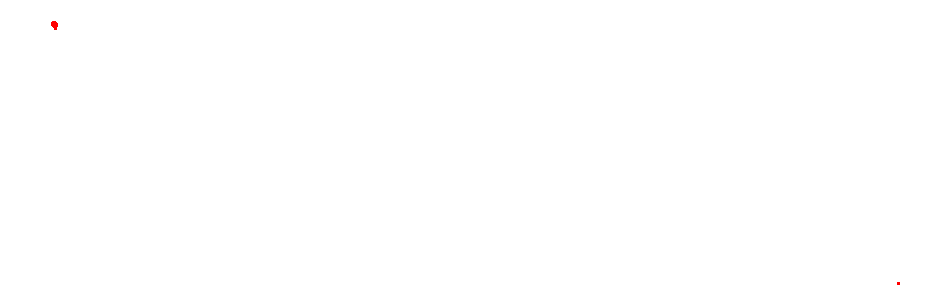

In [104]:
fig,ax = plt.subplots(figsize=(12,12))
arrests.plot(ax=ax,
            color='red',
            markersize=1)
ax.axis('off')
ctx.add.basemap(ax, source=ctx.providers.CartoDB.Position)

In [106]:
arrests[arrests.lon==0]

,Unnamed: 0,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
32,32,6267228,BOOKING,2021-10-23T00:00:00.000,1525.0,9,Van Nuys,964,34,M,...,5000 TILDEN AV,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2021-10-23T00:00:00.000,1813.0,VALLEY - JAIL DIV,4279.0,NaN,POINT (0.000 0.000)
54,54,6267242,BOOKING,2021-10-23T00:00:00.000,1745.0,13,Newton,1313,37,M,...,SAN PEDRO,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2021-10-23T00:00:00.000,1907.0,METRO - JAIL DIVISION,4273.0,WASHINGTON,POINT (0.000 0.000)
85,85,6267258,BOOKING,2021-10-23T00:00:00.000,1750.0,14,Pacific,1441,48,M,...,3000 BEACH AV,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2021-10-23T00:00:00.000,1940.0,PACIFIC,4214.0,NaN,POINT (0.000 0.000)
98,98,6267253,BOOKING,2021-10-23T00:00:00.000,1835.0,10,West Valley,1029,39,M,...,GLORIA,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2021-10-23T00:00:00.000,1933.0,VALLEY - JAIL DIV,4279.0,VANOWEN,POINT (0.000 0.000)
114,114,211420390,RFC,2021-10-23T00:00:00.000,1800.0,14,Pacific,1494,23,M,...,700 WORLD WAY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",NaN,NaN,NaN,NaN,NaN,POINT (0.000 0.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39005,39005,211409781,RFC,2021-04-01T00:00:00.000,1527.0,14,Pacific,1411,46,M,...,NAVY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",NaN,NaN,NaN,NaN,OCEAN FRONT WK,POINT (0.000 0.000)
39014,39014,211107182,RFC,2021-04-01T00:00:00.000,1445.0,11,Northeast,1141,28,M,...,HOLLYWOOD,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",NaN,NaN,NaN,NaN,BERENDO,POINT (0.000 0.000)
39144,39144,211507546,RFC,2021-04-01T00:00:00.000,910.0,15,N Hollywood,1591,61,F,...,LAUREL CANYON BL,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",NaN,NaN,NaN,NaN,VENTURA BL,POINT (0.000 0.000)
39168,39168,211308309,RFC,2021-04-01T00:00:00.000,1730.0,13,Newton,1381,20,M,...,5900 S BROADWAY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",NaN,NaN,NaN,NaN,NaN,POINT (0.000 0.000)


In [112]:
arrests= arrests[arrests.lon!=0]

AttributeError: module 'contextily' has no attribute 'add'

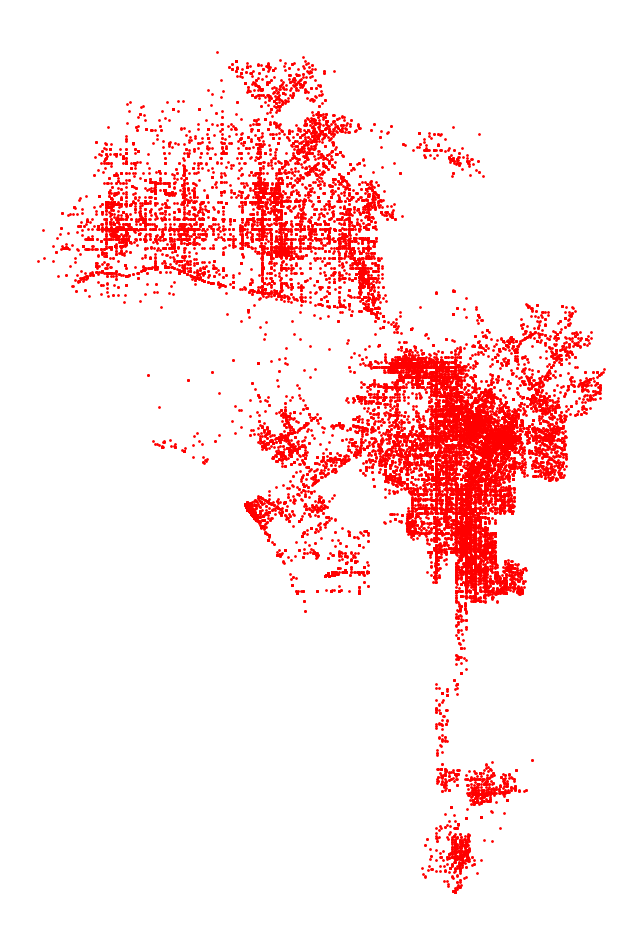

In [114]:
fig,ax = plt.subplots(figsize=(12,12))
arrests.plot(ax=ax,
            color='red',
            markersize=1)
ax.axis('off')
ctx.add.basemap(ax, source=ctx.providers.CartoDB.Position)